#### Problem Statement

Develop a minimum viable solution for the prediction of the rating for the given data set.

In [1]:
#immporting the required pakages

import pandas as pd
import numpy as np
import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.corpus import wordnet
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from string import punctuation
from sklearn.model_selection import train_test_split
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV,RepeatedStratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')

import pickle

pd.options.display.max_colwidth = 1000

In [2]:
#reading the data set for our analysis

df = pd.read_json('Musical_Instruments_5.json',lines = True)

In [3]:
#printing first few rows of the data set to get familiar with the data set

df.head(5)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A2IBPI20UZIR0U,1384719342,"cassandra tu ""Yeah, well, that's just like, u...","[0, 0]","Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,",5,good,1393545600,"02 28, 2014"
1,A14VAT5EAX3D9S,1384719342,Jake,"[13, 14]","The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]",5,Jake,1363392000,"03 16, 2013"
2,A195EZSQDW3E21,1384719342,"Rick Bennette ""Rick Bennette""","[1, 1]","The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. The double cloth filter blocks the pops and lets the voice through with no coloration. The metal clamp mount attaches to the mike stand secure enough to keep it attached. The goose neck needs a little coaxing to stay where you put it.",5,It Does The Job Well,1377648000,"08 28, 2013"
3,A2C00NNG1ZQQG2,1384719342,"RustyBill ""Sunday Rocker""","[0, 0]",Nice windscreen protects my MXL mic and prevents pops. Only thing is that the gooseneck is only marginally able to hold the screen in position and requires careful positioning of the clamp to avoid sagging.,5,GOOD WINDSCREEN FOR THE MONEY,1392336000,"02 14, 2014"
4,A94QU4C90B1AX,1384719342,SEAN MASLANKA,"[0, 0]",This pop filter is great. It looks and performs like a studio filter. If you're recording vocals this will eliminate the pops that gets recorded when you sing.,5,No more pops when I record my vocals.,1392940800,"02 21, 2014"


##### Understanding the data set

This data set consist of 9 columns   
Description of columns in the file:

1. reviewerID - ID of the reviewer
2. asin - ID of the product
3. reviewerName - name of the reviewer
4. helpful - helpfulness rating of the review
5. reviewText - text of the review
6. overall - rating of the product
7. summary - summary of the review
8. unixReviewTime - time of the review (unix time)
9. reviewTime - time of the review

In [4]:
#shape of the data set

df.shape

(10261, 9)

In [5]:
#checking the type of each columns

df.dtypes

reviewerID        object
asin              object
reviewerName      object
helpful           object
reviewText        object
overall            int64
summary           object
unixReviewTime     int64
reviewTime        object
dtype: object

In [6]:
#checking the null values in the data set

df.isnull().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

Their are no null values in the data set except in reviewerName column which is not even required for predicting the ratings.

In [7]:
#droping unwanted columns from our data set

cols = ['reviewerID','asin','reviewerName','helpful','unixReviewTime','reviewTime']

df.drop(columns = cols,inplace = True,axis = 1)

In [8]:
df.head(3)

,reviewText,overall,summary
0,"Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,",5,good
1,"The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]",5,Jake
2,"The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. The double cloth filter blocks the pops and lets the voice through with no coloration. The metal clamp mount attaches to the mike stand secure enough to keep it attached. The goose neck needs a little coaxing to stay where you put it.",5,It Does The Job Well


In [9]:
#checking for duplicate values in the data set

print('Total number of duplicate values in the data set is/are: ',df.duplicated().sum())

Total number of duplicate values in the data set is/are:  0


##### Pre Processing steps

Steps to be followed before we apply our algorithms for predicting the ratings from the data set.

In [10]:
#concatinating the reviewText and summary text into one column

df['text'] = df['reviewText'] + ' ' + df['summary']

In [11]:
df.head(3)

,reviewText,overall,summary,text
0,"Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing,",5,good,"Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing, good"
1,"The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :]",5,Jake,"The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :] Jake"
2,"The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. The double cloth filter blocks the pops and lets the voice through with no coloration. The metal clamp mount attaches to the mike stand secure enough to keep it attached. The goose neck needs a little coaxing to stay where you put it.",5,It Does The Job Well,"The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. The double cloth filter blocks the pops and lets the voice through with no coloration. The metal clamp mount attaches to the mike stand secure enough to keep it attached. The goose neck needs a little coaxing to stay where you put it. It Does The Job Well"


In [12]:
#dropping the unnecessary columns from our data set

df.drop(columns = ['reviewText','summary'],inplace = True,axis = 1)

In [13]:
df.head(3)

,overall,text
0,5,"Not much to write about here, but it does exactly what it's supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy it, they honestly work the same despite their pricing, good"
1,5,"The product does exactly as it should and is quite affordable.I did not realized it was double screened until it arrived, so it was even better than I had expected.As an added bonus, one of the screens carries a small hint of the smell of an old grape candy I used to buy, so for reminiscent's sake, I cannot stop putting the pop filter next to my nose and smelling it after recording. :DIf you needed a pop filter, this will work just as well as the expensive ones, and it may even come with a pleasing aroma like mine did!Buy this product! :] Jake"
2,5,"The primary job of this device is to block the breath that would otherwise produce a popping sound, while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. The double cloth filter blocks the pops and lets the voice through with no coloration. The metal clamp mount attaches to the mike stand secure enough to keep it attached. The goose neck needs a little coaxing to stay where you put it. It Does The Job Well"


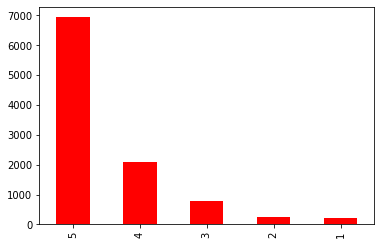

In [14]:
# checking for the balance in the data set with respect to rating

df.overall.value_counts().plot(kind='bar',color='red')

we can see that close to 70% of data set skewed towards rating 5 and very less data set is having 1,2,3,4 ratings which will make it difficult for our model to predict the correct ratings. we have to perform some pre processing steps to make it balance.

we will first combine 1,2 and 3 (poor) ratings together and mark it as 0 and 4 and 5 (good) as 1, then if required we will perform over/under sampling to balance our data set.

In [15]:
#combining the ratings together

def mergerating(rating):
    # Replacing ratings of 1,2,3 with 0 (poor) and 4,5 with 1 (good)
    if(int(rating) == 1 or int(rating) == 2 or int(rating) == 3):
        return 0
    else: 
        return 1
df.overall = df.overall.apply(mergerating) 

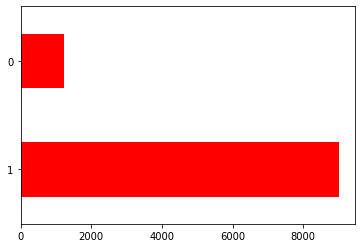

In [16]:
#after merging

df.overall.value_counts().plot(kind='barh',color='red')

we have to perform over/under sampling with the data set to make it balanced but before we will complete our pre processing steps first and then will do balancing of data set.

In [18]:
#function to convert text into lower case

def lower_case(text):
    return text.lower()


In [19]:
#Remove non ASCII values from the text if any for this we will use ord() to find ASCII value of the character
#Assumption: we will only use range of ASCII value from 0-128
def strip_non_ascii(data_str):
    ''' Returns the string without non ASCII characters'''
    stripped = (c for c in data_str if 0 < ord(c) < 127)
    return ''.join(stripped)

In [20]:
# Fix Abbreviations

def fix_abbreviation(data_str):
    data_str = data_str.lower()
    data_str = re.sub(r'\bthats\b', 'that is', data_str)
    data_str = re.sub(r'\bive\b', 'i have', data_str)
    data_str = re.sub(r'\bim\b', 'i am', data_str)
    data_str = re.sub(r'\bya\b', 'yeah', data_str)
    data_str = re.sub(r'\bcant\b', 'can not', data_str)
    data_str = re.sub(r'\bdont\b', 'do not', data_str)
    data_str = re.sub(r'\bwont\b', 'will not', data_str)
    data_str = re.sub(r'wtf', 'what the fuck', data_str)
    data_str = re.sub(r'\bwth\b', 'what the hell', data_str)
    data_str = re.sub(r'\br\b', 'are', data_str)
    data_str = re.sub(r'\bu\b', 'you', data_str)
    data_str = re.sub(r'\bk\b', 'OK', data_str)
    data_str = re.sub(r'\bsux\b', 'sucks', data_str)
    data_str = data_str.strip()
    return data_str

In [21]:
##Remove punctuations mentions and alphanumeric characters

def remove_features(data_str):
# compile regex
    url_re = re.compile('https?://(www.)?\w+\.\w+(/\w+)*/?')
    num_re = re.compile('(\\d+)')
    mention_re = re.compile('@(\w+)')
    alpha_num_re = re.compile("^[a-z0-9_.]+$")
# convert to lowercase
    data_str = data_str.lower()
# remove hyperlinks
    data_str = url_re.sub(' ', data_str)
# remove @mentions
    data_str = mention_re.sub(' ', data_str)
# remove numeric 'words'
    data_str = num_re.sub(' ', data_str)
# remove non a-z 0-9 characters and words shorter than 1 characters
    list_pos = 0
    cleaned_str = ''
    for word in data_str.split():
        if list_pos == 0:
            if alpha_num_re.match(word):
                cleaned_str = word
            else:
                cleaned_str = ' '
        else:
            if alpha_num_re.match(word):
                cleaned_str = cleaned_str + ' ' + word
            else:
                cleaned_str += ' '
        list_pos += 1
# remove unwanted space, *.split() will automatically split on
# whitespace and discard duplicates, the " ".join() joins the
# resulting list into one string.
    return " ".join(cleaned_str.split())

In [ ]:
def get_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

The POS tagger in the NLTK library outputs specific tags for certain words. The list of POS tags is as follows, with examples of what each POS stands for.

CC coordinating conjunction    
CD cardinal digit     
DT determiner     
EX existential there (like: “there is” … think of it like “there exists”)    
FW foreign word    
IN preposition/subordinating conjunction    
JJ adjective ‘big’   
JJR adjective, comparative ‘bigger’    
JJS adjective, superlative ‘biggest’     
LS list marker 1)    
MD modal could, will     
NN noun, singular ‘desk’    
NNS noun plural ‘desks’       
NNP proper noun, singular ‘Harrison’     
NNPS proper noun, plural ‘Americans’     
VB verb, base form take     
VBD verb, past tense took      
VBG verb, gerund/present participle taking     
VBN verb, past participle taken     
VBP verb, sing. present, non-3d take    
VBZ verb, 3rd person sing. present takes      
PDT predeterminer ‘all the kids’    
  

POS possessive ending parent’s              
PRP personal pronoun I, he, she               
PRP$ possessive pronoun my, his, hers                  
RB adverb very, silently,                        
RBR adverb, comparative better                         
RBS adverb, superlative best                         
RP particle give up                               
TO, to go ‘to’ the store                             
UH interjection, errrrrrrrm                               
WDT wh-determiner which                                   
WP wh-pronoun who, what                                     
WP$ possessive wh-pronoun whose                                       
WRB wh-abverb where, when                                             

out of all the tags we are only intrested in verbs, adjectives and nouns, so we will be using only
###### JJ adjective ‘big’   
###### JJR adjective, comparative ‘bigger’    
###### JJS adjective, superlative ‘biggest’     
###### NN noun, singular ‘desk’    
###### NNS noun plural ‘desks’       
###### NNP proper noun, singular ‘Harrison’     
###### NNPS proper noun, plural ‘Americans’     
###### VB verb, base form take     
###### VBD verb, past tense took      
###### VBG verb, gerund/present participle taking     
###### VBN verb, past participle taken     
###### VBP verb, sing. present, non-3d take    
###### VBZ verb, 3rd person sing. present takes 

In [23]:
#Lemmatization
def lemmatize(data_str):
# expects a string
    list_pos = 0
    cleaned_str = ''
    final_text=[]
    lmtzr = WordNetLemmatizer()
    stop = set(stopwords.words('english'))
    punc = list(punctuation)
    stop.update(punc)
    for i in data_str.split():
        if i.strip().lower() not in stop:
            pos = pos_tag([i.strip()])
            if get_pos(pos[0][1]) is None:
                pass
            else:
                word = lmtzr.lemmatize(i.strip(),get_pos(pos[0][1]))
                final_text.append(word.lower())
    return " ".join(final_text)
    

In [24]:
#converting the text into lower case

df.text = df.text.apply(lower_case)

In [25]:
#removing the non ASCII characters from the text

df.text = df.text.apply(strip_non_ascii)

In [26]:
#removing the abbreviations from the text

df.text = df.text.apply(fix_abbreviation)

In [27]:
#removing unwanted characters from the text such as numbers or alpha numeric characters and hyperlinks

df.text = df.text.apply(remove_features)

In [28]:
df.head(3)

,overall,text
0,1,not much to write about but it does exactly what supposed to. filters out the pop sounds. now my recordings are much more crisp. it is one of the lowest prices pop filters on amazon so might as well buy they honestly work the same despite their good
1,1,the product does exactly as it should and is quite affordable.i did not realized it was double screened until it so it was even better than i had expected.as an added one of the screens carries a small hint of the smell of an old grape candy i used to so for i cannot stop putting the pop filter next to my nose and smelling it after recording. you needed a pop this will work just as well as the expensive and it may even come with a pleasing aroma like mine this jake
2,1,the primary job of this device is to block the breath that would otherwise produce a popping while allowing your voice to pass through with no noticeable reduction of volume or high frequencies. the double cloth filter blocks the pops and lets the voice through with no coloration. the metal clamp mount attaches to the mike stand secure enough to keep it attached. the goose neck needs a little coaxing to stay where you put it. it does the job well


In [29]:
df.text = df.text.apply(lemmatize)

In [30]:
df.head(3)

,overall,text
0,1,much write exactly suppose to. filter pop sounds. recording much crisp. low price pop filter amazon well buy honestly work good
1,1,product exactly quite affordable.i realize double screen even well expected.as add screen carry small hint smell old grape candy use cannot stop put pop filter next nose smell recording. need pop work well expensive even come please aroma mine jake
2,1,primary job device block breath otherwise produce pop allow voice pas noticeable reduction volume high frequencies. double cloth filter block pop let voice coloration. metal clamp mount attache mike stand secure enough keep attached. goose neck need little coax stay put it. job well


##### splitting the data set into 80-20  
while splitting the data set we will make sure that both the classes are equally divided into both train and test to avoid any ambiguity in the model training and model validation for this we will mark stratify property of train_test_split function with our target variable.

In [31]:
X_train, X_test, y_train, y_test = train_test_split(df.text, df.overall, test_size=0.2, random_state=1,stratify = df.overall)

##### checking for imbalance in the data set

In [32]:
Counter(y_train)

Counter({1: 7217, 0: 991})

In [33]:
Counter(y_test)

Counter({1: 1805, 0: 248})

In [34]:
print("Percentage of 0 class in data:", len(df[df['overall']==0])*100/len(df))

Percentage of 0 class in data: 12.07484650618848


In [35]:
print("Percentage of 1 class in data:", len(df[df['overall']==1])*100/len(df))

Percentage of 1 class in data: 87.92515349381152


it seems to be class imbalanced issue we will apply our feature extraction and then before applying models we will perform over and under sampling to make the data set balance. Once the data set is balance we will train our model.

In [36]:
# creating a set for good and bad ratings to create a word cloud
good_ratings = X_train[y_train[y_train == 1].index]
poor_ratings = X_train[y_train[y_train == 0].index]

##### printing word cloud for poor ratings

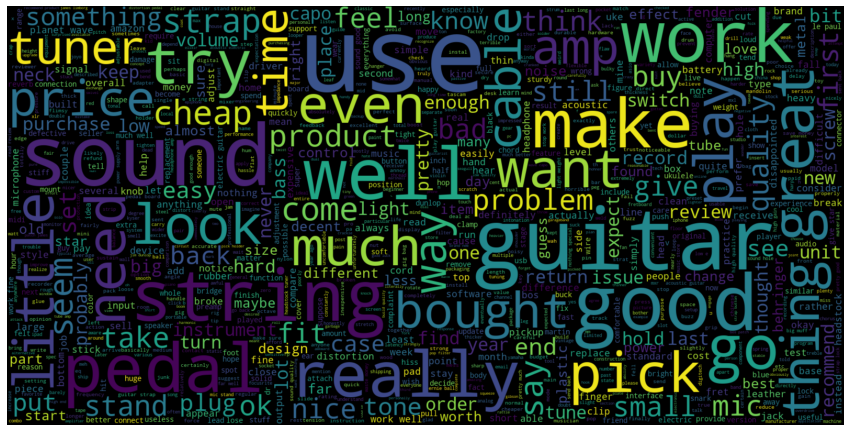

In [37]:
wc = WordCloud(background_color='black',max_font_size=200,min_font_size = 3,  max_words = 1000 , width = 1600 , height = 800,random_state=1).generate(" ".join(poor_ratings))
plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(wc,interpolation = 'bilinear')

##### printing word cloud for good words

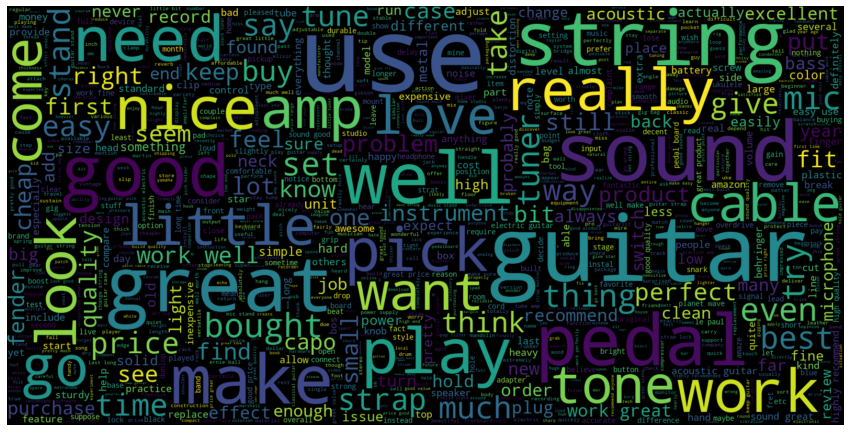

In [38]:
wc = WordCloud(background_color='black',max_font_size=200,min_font_size = 3,  max_words = 1000 , width = 1600 , height = 800,random_state=1).generate(" ".join(good_ratings))
plt.figure(figsize=(15, 10))
plt.axis('off')
plt.imshow(wc,interpolation = 'bilinear')

##### converting the text into numeric features so that our ML model can get trained, we will use TFIDF and Bag of Words technique for this we will create a pipeline for this and train with different models

##### Naive bayes

Naive Bayes with TFIDF

In [39]:
mnb=MultinomialNB()

tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
over = RandomOverSampler(sampling_strategy=0.5,random_state = 1)
under = RandomUnderSampler(sampling_strategy='majority', random_state = 1)
steps = [('t',tv),
         ('o',over),
         ('u',under),
         
#          ('smo',res),
         ('m',mnb)]
pipeline = Pipeline(steps=steps)

In [40]:
model_nb_tv = pipeline.fit(X_train,y_train)

In [41]:
y_pred_nb_tv = model_nb_tv.predict(X_test)

In [42]:
confusion_matrix(y_test, y_pred_nb_tv)

array([[ 111,  137],
       [ 498, 1307]], dtype=int64)

In [43]:
print(classification_report(y_test,y_pred_nb_tv))

              precision    recall  f1-score   support

           0       0.18      0.45      0.26       248
           1       0.91      0.72      0.80      1805

    accuracy                           0.69      2053
   macro avg       0.54      0.59      0.53      2053
weighted avg       0.82      0.69      0.74      2053



In [44]:
print('Accuracy of model:', metrics.accuracy_score(y_test, y_pred_nb_tv))
print('Precision of model:', metrics.precision_score(y_test, y_pred_nb_tv))
print('recall of model:',metrics.recall_score(y_test, y_pred_nb_tv))
print('F1 Score of model:', metrics.f1_score(y_test, y_pred_nb_tv))
print('ROC AUC score of model:', metrics.roc_auc_score(y_test, y_pred_nb_tv))

Accuracy of model: 0.6906965416463712
Precision of model: 0.9051246537396122
recall of model: 0.7240997229916898
F1 Score of model: 0.8045552477685443
ROC AUC score of model: 0.5858401840764901


Naive Bayes with Bag of Words

In [45]:
mnb=MultinomialNB()

cvr=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
over = RandomOverSampler(sampling_strategy=0.5,random_state = 1)
under = RandomUnderSampler(sampling_strategy='majority', random_state = 1)
steps = [('c',cvr),
         ('o',over),
         ('u',under),
         
#          ('smo',res),
         ('m',mnb)]
pipeline = Pipeline(steps=steps)

In [46]:
model_nb_cvr = pipeline.fit(X_train,y_train)

In [47]:
y_pred_nb_cvr = model_nb_cvr.predict(X_test)

In [48]:
confusion_matrix(y_test, y_pred_nb_cvr)

array([[  90,  158],
       [ 418, 1387]], dtype=int64)

In [49]:
print(classification_report(y_test,y_pred_nb_cvr))

              precision    recall  f1-score   support

           0       0.18      0.36      0.24       248
           1       0.90      0.77      0.83      1805

    accuracy                           0.72      2053
   macro avg       0.54      0.57      0.53      2053
weighted avg       0.81      0.72      0.76      2053



In [50]:
print('Accuracy of model:', metrics.accuracy_score(y_test, y_pred_nb_cvr))
print('Precision of model:', metrics.precision_score(y_test, y_pred_nb_cvr))
print('recall of model:',metrics.recall_score(y_test, y_pred_nb_cvr))
print('F1 Score of model:', metrics.f1_score(y_test, y_pred_nb_cvr))
print('ROC AUC score of model:', metrics.roc_auc_score(y_test, y_pred_nb_cvr))

Accuracy of model: 0.7194349732099367
Precision of model: 0.8977346278317152
recall of model: 0.7684210526315789
F1 Score of model: 0.8280597014925374
ROC AUC score of model: 0.5656621392190152


##### Logistic Regression

Logistic regressio with TFIDF

In [51]:
from imblearn.combine import SMOTEENN
# res = SMOTEENN(sampling_strategy=0.8,random_state = 1)
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
over = RandomOverSampler(sampling_strategy=0.5,random_state = 1)
under = RandomUnderSampler(sampling_strategy='majority', random_state = 1)
steps = [('t',tv),
         ('o',over),
         ('u',under),
         
#          ('smo',res),
         ('m',LogisticRegression())]
pipeline = Pipeline(steps=steps)

In [52]:
model_lr_tv = pipeline.fit(X_train,y_train)

y_pred_lr_tv = model_lr_tv.predict(X_test)



In [53]:
confusion_matrix(y_test, y_pred_lr_tv)


array([[   2,  246],
       [   3, 1802]], dtype=int64)

In [54]:
print(classification_report(y_test,y_pred_lr_tv))

              precision    recall  f1-score   support

           0       0.40      0.01      0.02       248
           1       0.88      1.00      0.94      1805

    accuracy                           0.88      2053
   macro avg       0.64      0.50      0.48      2053
weighted avg       0.82      0.88      0.82      2053



In [55]:
print('Accuracy of model:', metrics.accuracy_score(y_test, y_pred_lr_tv))
print('Precision of model:', metrics.precision_score(y_test, y_pred_lr_tv))
print('recall of model:',metrics.recall_score(y_test, y_pred_lr_tv))
print('F1 Score of model:', metrics.f1_score(y_test, y_pred_lr_tv))
print('ROC AUC score of model:', metrics.roc_auc_score(y_test, y_pred_lr_tv))

Accuracy of model: 0.8787140769605456
Precision of model: 0.8798828125
recall of model: 0.9983379501385041
F1 Score of model: 0.9353750324422528
ROC AUC score of model: 0.5032012331337682


Logistic Regression with Bag of Words

In [64]:
over = RandomOverSampler(sampling_strategy=0.3,random_state = 1)
under = RandomUnderSampler(sampling_strategy='majority', random_state = 1)
cvr=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
steps = [('c',cvr),
         ('o',over),
         ('u',under),
         ('m',LogisticRegression())]
pipeline = Pipeline(steps=steps)


In [65]:
model_lr_cvr = pipeline.fit(X_train,y_train)

y_pred_lr_cvr = model_lr_cvr.predict(X_test)



In [66]:
confusion_matrix(y_test, y_pred_lr_cvr)


array([[   1,  247],
       [   3, 1802]], dtype=int64)

In [67]:
print(classification_report(y_test,y_pred_lr_cvr))

              precision    recall  f1-score   support

           0       0.25      0.00      0.01       248
           1       0.88      1.00      0.94      1805

    accuracy                           0.88      2053
   macro avg       0.56      0.50      0.47      2053
weighted avg       0.80      0.88      0.82      2053



In [68]:
print('Accuracy of model:', metrics.accuracy_score(y_test, y_pred_lr_cvr))
print('Precision of model:', metrics.precision_score(y_test, y_pred_lr_cvr))
print('recall of model:',metrics.recall_score(y_test, y_pred_lr_cvr))
print('F1 Score of model:', metrics.f1_score(y_test, y_pred_lr_cvr))
print('ROC AUC score of model:', metrics.roc_auc_score(y_test, y_pred_lr_cvr))

Accuracy of model: 0.8782269849001462
Precision of model: 0.879453391898487
recall of model: 0.9983379501385041
F1 Score of model: 0.9351323300467047
ROC AUC score of model: 0.5011851041015102


##### Random Forest

Random Forest with Bag of Words

In [75]:
over = RandomOverSampler(sampling_strategy=0.3,random_state = 1)
under = RandomUnderSampler(sampling_strategy='majority', random_state = 1)
cvr=CountVectorizer(min_df=0,max_df=1,binary=False,ngram_range=(1,3))
steps = [('c',cvr),
         ('o',over),
         ('u',under),
         ('m',RandomForestClassifier(random_state = 1))]
pipeline = Pipeline(steps=steps)
# rf = RandomForestClassifier(random_state = 1)


In [76]:
model_rf_cvr = pipeline.fit(X_train,y_train)

y_pred_rf_cvr = model_rf_cvr.predict(X_test)

In [77]:
confusion_matrix(y_test, y_pred_rf_cvr)

array([[   1,  247],
       [   3, 1802]], dtype=int64)

In [78]:
print(classification_report(y_test,y_pred_rf_cvr))

              precision    recall  f1-score   support

           0       0.25      0.00      0.01       248
           1       0.88      1.00      0.94      1805

    accuracy                           0.88      2053
   macro avg       0.56      0.50      0.47      2053
weighted avg       0.80      0.88      0.82      2053



In [79]:
print('Accuracy of model:', metrics.accuracy_score(y_test, y_pred_rf_cvr))
print('Precision of model:', metrics.precision_score(y_test, y_pred_rf_cvr))
print('recall of model:',metrics.recall_score(y_test, y_pred_rf_cvr))
print('F1 Score of model:', metrics.f1_score(y_test, y_pred_rf_cvr))
print('ROC AUC score of model:', metrics.roc_auc_score(y_test, y_pred_rf_cvr))

Accuracy of model: 0.8782269849001462
Precision of model: 0.879453391898487
recall of model: 0.9983379501385041
F1 Score of model: 0.9351323300467047
ROC AUC score of model: 0.5011851041015102


Random Forest Classifier with TFIDF

In [80]:
tv=TfidfVectorizer(min_df=0,max_df=1,use_idf=True,ngram_range=(1,3))
over = RandomOverSampler(sampling_strategy=0.3,random_state = 1)
under = RandomUnderSampler(sampling_strategy='majority', random_state = 1)
steps = [('tv',tv),
         ('o',over),
         ('u',under),
         ('m',RandomForestClassifier(random_state = 1))]
pipeline = Pipeline(steps=steps)
# rf = RandomForestClassifier(random_state = 1)


In [81]:
model_rf_tv = pipeline.fit(X_train,y_train)

y_pred_rf_tv = model_rf_tv.predict(X_test)

In [82]:
confusion_matrix(y_test, y_pred_rf_tv)

array([[   1,  247],
       [   3, 1802]], dtype=int64)

In [83]:
print(classification_report(y_test,y_pred_rf_tv))

              precision    recall  f1-score   support

           0       0.25      0.00      0.01       248
           1       0.88      1.00      0.94      1805

    accuracy                           0.88      2053
   macro avg       0.56      0.50      0.47      2053
weighted avg       0.80      0.88      0.82      2053



In [84]:
print('Accuracy of model:', metrics.accuracy_score(y_test, y_pred_rf_tv))
print('Precision of model:', metrics.precision_score(y_test, y_pred_rf_tv))
print('recall of model:',metrics.recall_score(y_test, y_pred_rf_tv))
print('F1 Score of model:', metrics.f1_score(y_test, y_pred_rf_tv))
print('ROC AUC score of model:', metrics.roc_auc_score(y_test, y_pred_rf_tv))

Accuracy of model: 0.8782269849001462
Precision of model: 0.879453391898487
recall of model: 0.9983379501385041
F1 Score of model: 0.9351323300467047
ROC AUC score of model: 0.5011851041015102


In [85]:
# # finding the best parameter from our cross validation
# param_grid_rf = {
#     'm__max_depth': [80, 90],
#     'm__min_samples_leaf': [3, 4, 5],
#     'm__min_samples_split': [8, 10],
#     'm__n_estimators': [150,250]
# }
# grid_search_rf = GridSearchCV(estimator = pipeline, param_grid = param_grid_rf, cv = 5, verbose = 2)
# grid_search_rf.fit(X_train, y_train)
# grid_search_rf.best_params_

In [86]:

# # we are creating model out of the best grid generated by the cross validation
# best_grid_rf = grid_search_rf.best_estimator_

In [87]:

# # predicting the values using X_test data set
# y_pred_rf = best_grid_rf.predict(X_test)

In [88]:
# # Printing confusion matrix with random forest
# confusion_matrix(y_test, y_pred_rf)

In [89]:

# # Printing Classification report with random forest
# print(classification_report(y_test,y_pred_rf))

In [90]:
import statistics
final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred, statistics.mode([y_pred_nb_tv[i], y_pred_nb_cvr[i],y_pred_lr_tv[i]]))

In [91]:
confusion_matrix(y_test, final_pred)

array([[  89,  159],
       [ 402, 1403]], dtype=int64)

In [92]:
print(classification_report(y_test,final_pred))

              precision    recall  f1-score   support

           0       0.18      0.36      0.24       248
           1       0.90      0.78      0.83      1805

    accuracy                           0.73      2053
   macro avg       0.54      0.57      0.54      2053
weighted avg       0.81      0.73      0.76      2053



In [93]:
print('Accuracy of model:', metrics.accuracy_score(y_test, final_pred))
print('Precision of model:', metrics.precision_score(y_test, final_pred))
print('recall of model:',metrics.recall_score(y_test, final_pred))
print('F1 Score of model:', metrics.f1_score(y_test, final_pred))
print('ROC AUC score of model:', metrics.roc_auc_score(y_test, final_pred))

Accuracy of model: 0.7267413541159279
Precision of model: 0.8982074263764405
recall of model: 0.7772853185595567
F1 Score of model: 0.8333828333828334
ROC AUC score of model: 0.5680781431507461


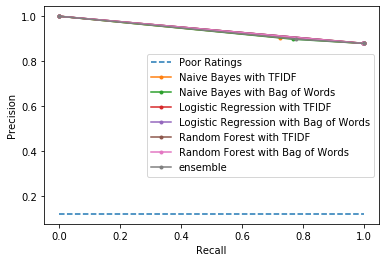

In [94]:
from matplotlib import pyplot
non_defaults = len(y_train[y_train==0]) / len(y_train)
# plot the no skill precision-recall curve
pyplot.plot([0, 1], [non_defaults, non_defaults], linestyle='--', label='Poor Ratings')
precision, recall, _ = metrics.precision_recall_curve(y_test, final_pred)
precision_nb_tv, recall_nb_tv, _ = metrics.precision_recall_curve(y_test, y_pred_nb_tv)
precision_nb_cvr, recall_nb_cvr, _ = metrics.precision_recall_curve(y_test, y_pred_nb_cvr)
precision_lr_tv, recall_lr_tv, _ = metrics.precision_recall_curve(y_test, y_pred_lr_tv)
precision_lr_cvr, recall_lr_cvr, _ = metrics.precision_recall_curve(y_test, y_pred_lr_cvr)
precision_rf_tv, recall_rf_tv, _ = metrics.precision_recall_curve(y_test, y_pred_rf_tv)
precision_rf_cvr, recall_rf_cvr, _ = metrics.precision_recall_curve(y_test, y_pred_rf_cvr)
pyplot.plot(recall_nb_tv, precision_nb_tv, marker='.', label='Naive Bayes with TFIDF')
pyplot.plot(recall_nb_cvr, precision_nb_cvr, marker='.', label='Naive Bayes with Bag of Words')
pyplot.plot(recall_lr_tv, precision_lr_tv, marker='.', label='Logistic Regression with TFIDF')
pyplot.plot(recall_lr_cvr, precision_lr_cvr, marker='.', label='Logistic Regression with Bag of Words')
pyplot.plot(recall_rf_tv, precision_rf_tv, marker='.', label='Random Forest with TFIDF')
pyplot.plot(recall_rf_cvr, precision_rf_cvr, marker='.', label='Random Forest with Bag of Words')
pyplot.plot(recall, precision, marker='.', label='ensemble')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()


In [95]:
# Saving model to disk
pickle.dump(model_nb_tv, open('model_nb_tv.pkl', 'wb'))
pickle.dump(model_nb_cvr, open('model_nb_cvr.pkl', 'wb'))
pickle.dump(model_lr_tv, open('model_lr_tv.pkl', 'wb'))